# Halpha cubes from a simulated disk galaxy

This tutorial processes the outputs of a RHD simulation of an idealised disk galaxy in order to generate a few spectra, images, and data-cubes around the H-alpha line. It models both the line emission and the stellar continuum, and accounts for light propagation through the dusty ISM. 

This notebook is a step-by-step guide to producing example mock data. In practice, all the parameter files generated below can be edited independently, and the codes that are run from the notebook can also be run from the terminal. 

## 0. Before anything ... 
A few things need to be done before you can start this tutorial: 
- __Download a simulation output [at this link](https://nuage.osupytheas.fr/s/oQfSXo9y86PonNY)__. Warning: the tar file is 4GB, so this will take time. The tar file `output_00018.tar` will expand into a directory named `output_00018` that you should move to some path. Provide this path to the variable `repository` below ([in this cell](#repo)).

- __Download SED libraries [at this link](https://nuage.osupytheas.fr/s/gsWNprsyBZKLsay)__. Warning: the tar file is 700MB. This will expand into a directory `seds-for-tutorial` containing SEDs from different libraries, all converted to the RAMSES-RT format. Provide the path to your `seds-for-tutorial` directory in the `SSPdir` variables below ([in this cell](#SSPDir))

- **compile the codes**:
From the rascas directory, go into the `rascas/f90` directory and type `make all F90=mpif90`. This will work if you have an MPI library set up. If you'd rather not use MPI use instead `make all F90=gfortran MPI=0`. 


### Warning

For idealised disk galaxy simulations, there are stars in the initial conditions. These may not have defined values of age and metallicity. Make sure to read them correctly as stars and not dark matter and to set their ages and metallicity, since they do contribute to the stellar continuum.


## 1. Preparation : imports, paths, and target definition
### 1.1. Imports

In [1]:
# Set the path to the rascas directory (could be an absolute path)
RascasDir       = '../../../' 
import sys
sys.path.append("%s/py/"%(RascasDir))

# imports from the RASCAS library
import write_param_files as wpf
import jphot as jp
from mocks import mockobs

In [2]:
# standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy import units as u
from astropy import constants as cst

In [3]:
# a useful function to get units from ramses outputs
def get_info_param_real(RamsesDir,timestep,pname):
    """ reads the value of a parameter from a ramses info file. 
    inputs: 
    - RamsesDir : where the directories output_xxxxx are found.
    - timestep : the snapshot number
    - pname : the name of the parameter to search for in the info file. 
    """
    file = RamsesDir+'/output_%5.5i'%timestep+'/info_%5.5i.txt'%timestep
    f = open(file,'r')
    lines = f.readlines()
    f.close()
    for l in lines:
        if pname in l:
            p = np.float64(l.split(sep='=')[1])
            return p


### 1.2. Paths

**The following paths need to be updated to match your setup.**

`ExperimentDir` is where the RASCAS run will happen. This is where parameter files and output files will be written. This can be any absolute path, but here we use the local tutorial directory, specifying a relative path. 

In [4]:
ExperimentDir   = './'  

<a id="repo"></a>
`repository` gives the path to RAMSES outputs that will be processes. This directory 
contains the usual collection of `output_xxxxx` directories.

In [5]:
repository = '../RASCAS_data/diskSimulation/'

<a id="SSPDir"></a>
We will need spectra from stellar populations. Below we provide a path to SED libraries which are pre-formated (in the same format as for RAMSES-RT). This is done in two steps for clarity: (1) give path to your `seds-for-tutorial` directory, (2) add the path within that to the library you wish to use. 

In [6]:
SSPdir = '../RASCAS_data/seds-for-tutorials/'   ## this is the path to seds-for-tutorial dir
SSPdir = SSPdir + 'bpass_v221_chab100/'         ## this is where you chose a model

### 1.3. Defining the target

We now need to define the target galaxy. This involves defining the timestep at which we will mock-observe the simulation (through variable `snapnum`), the coordinates of the galaxy at that timestep. These coordinates given by the variables `target_x`, `target_y`, and `target_z`, and provided in box units (i.e. with values between 0 and 1). 

These are hard-coded below for the purpose of the tutorial but can be anything. For an idealised disk simulation, the coordinates are typically at the center of the box. 

In [7]:
snapnum  = 18
target_x = 0.5  # box units
target_y = 0.5  # box units
target_z = 0.5  # box units
target_position = np.array([target_x,target_y,target_z]) # useful later. 

We also need to specify the target geometry and size. RASCAS will compute the emission from star particles and gas cells within the target volume, and propagate Monte Carlo photon packets until the escape that volume. Different volumes are possible in principle (cube, slab, sphere, shell, ...) but for constructing mocks as we do here, the sphere is the most convenient. 

Below, we thus assume the region to be a sphere and we define its radius via the variable `target_r` (again in **box units**).  

In [11]:
target_r = 0.05 # box units

At this stage, one may want to express the target radius in proper kpc... We do this below as an example. 

In [12]:
unit_l = get_info_param_real(repository,snapnum,'unit_l') # read unit_l from info file to convert box units to cm
boxlen = get_info_param_real(repository,snapnum,'boxlen') # read boxlen for idealised sims
cu2cm = boxlen*unit_l
target_r_units = target_r * cu2cm * u.cm
print(target_r_units.to('kpc'))

14.999999998982235 kpc


### 1.4. Defining the wavelength range

We have to define the range of wavelengths that will be covered by our mocks. Below we use a couple of simple functions to set that range in terms of velocity offset from the H-alpha line center. 

The variables `vmin` and `vmax` give the velocity range, and are converted into `lmin` and `lmax` which give (in Angstrom) the wavelength range that will be passed to RASCAS. 

In [13]:
Halpha_lambda0 = 6562.8 * u.Angstrom  #
Halpha_nu0 = cst.c / Halpha_lambda0

def v_from_lambda(lbda):
    nu = cst.c / lbda
    v  = Halpha_lambda0 * (Halpha_nu0 - nu)
    return v.to('km/s')

def lambda_from_v(v):
    lbda = Halpha_lambda0 / ( 1 - v/cst.c) 
    return lbda.to('Angstrom')

vmin = -500 * u.km/u.s; lmin = lambda_from_v(vmin)
vmax =  500 * u.km/u.s; lmax = lambda_from_v(vmax)
print('Wavelength rage to cover %.1f km/s to %.1f km/s around Ha :'%(vmin.value,vmax.value))
print('%.2f Angstrom to %.2f Angstrom'%(lmin.value,lmax.value))

Wavelength rage to cover -500.0 km/s to 500.0 km/s around Ha :
6551.87 Angstrom to 6573.76 Angstrom


## 2. Set up mock instruments and observers

We now define the parameters specific to the mock observations. These parameters include:

- pointings : the direction of observation, along with the target position provided above;
- instrumental specifications: properties of spectroscope, imager, spectro-imager in terms of ranges, resolution and aperture.

The resulting parameters are written to a user-unfriendly file `mock_param_file.txt` in the `ExperimentDir` directory. This file is later used by `rascas`.

NB: one may chose to produce either a spectrum, or an image, or a cube, or any combination of that. 

### 2.1. Pointing

We may generate any number of mocks in one RASCAS run, so we define a few directions of observations below. 

NB: the computing time scales with the number of mocks, and the memory footprint as well, which quickly becomes a limiting factor when producing mock data cubes. 

In [14]:
# draw a few directions from edge-on to face-on
nmocks   = 3  # how many pointings
theta = np.linspace(0,np.pi/2.,nmocks)
kobs = []
for t in theta:
    kobs.append(np.array([0,np.cos(t),np.sin(t)]))  # observe along the y direction (make sure k is normalised)

### 2.2. Spectroscopy
The spectroscopic observations are defined by a wavelength range (`lambda_min` and `lambda_max` in Angstrom), a spectral resolution (given by the number of pixels `spec_npix`), and a circular aperture through which photons are collected (specified in terms of its radius by the `aperture` parameter, in box units). These parameters are passed to a class `specParams` (which will handle formatting parameters) to define the objec `spec`. 

In [15]:
aperture   = target_r # we choose the target radius here so we include all photons
# For the 1D spectra, we want a extended wavelength range to have the continuum.
vmin = -2000 * u.km/u.s; lmin = lambda_from_v(vmin)
vmax =  2000 * u.km/u.s; lmax = lambda_from_v(vmax)
spec_lambda_min = lmin.to('Angstrom').value # min wavelength (Angstrom)
spec_lambda_max = lmax.to('Angstrom').value # max wavelength (Angstrom)
spec_npix  = 80       # the nb of wavelength bins -> resolution of 50km/s
spec       = wpf.specParams(spec_npix,aperture,spec_lambda_min,spec_lambda_max)

### 2.3. Imaging
Images are always square here and are defined by a number of pixels on a side (stored into variable `im_npix`) and a size in box units (stored into variable `im_size`). These are used to define the object `image` which will be used later. 

In [16]:
im_npix = 150        # nb of pixels on a side
size    = 2*target_r # size of the image (side) -> view the full domain 
image   = wpf.imageParams(im_npix,size)

### 2.4. Spectro-imaging
Cubes are defined by their spectral and imaging properties. We define them as above and use the `cubeParams` class to save the information into a `cube` object. 

In [17]:
# The cubes are more expensive in memory so we narrow down the wavelength range
vmin = -400 * u.km/u.s; lmin = lambda_from_v(vmin)
vmax =  400 * u.km/u.s; lmax = lambda_from_v(vmax)
cube_lambda_min = lmin.to('Angstrom').value # min wavelength (Angstrom)
cube_lambda_max = lmax.to('Angstrom').value # max wavelength (Angstrom)
lbda_npix  = 40  # -> 20km/s resolution

image_npix = 50
size       = target_r * 0.2 # zoom-in on the galaxy. 
cube = wpf.cubeParams(lbda_npix,image_npix,cube_lambda_min,cube_lambda_max,size)

### 2.5. wrapping up
We now define the object containing all the above information for each direction and write it into some file with a specific unfriendly format. This file will later be read with RASCAS. 

In [18]:
mock_params_file = '%s/mock_param_file.txt'%ExperimentDir
f = open(mock_params_file,'w')
for k in kobs:
    p = wpf.pointing(k,target_position,spec=spec,image=image,cube=cube)
    p.write(f)
f.close()

## 3. Run the RASCAS suite of codes 
The RASCAS suite works in three steps: 
- Generate initial conditions for the sources of radiation, i.e. generate photon packets which sample each type of source (star particles or gas). 
- Extract from RAMSES outputs the gas (and dust) distribution in the computational volume. 
- Actually compute the radiation transfer. 

### 3.1. The source :  photon packets initial conditions
Here we write parameter files and execute the codes `PhotonsFromStars` and `HaPhotonsFromGas`. These are serial codes which read ramses outputs, compute the luminosities of star particles and gas cells and generate a sampling of these in the form of photon packets.

Most parameters below have been defined above. Some are free and may be changed. In particular, the number of photon packets to use will determine the signal-to-noise in the results (and the computing time). This number is different for continuum (where photons are distributed over a wide range of wavelength) and line emission. 

In [19]:
Parameters = []  # initialise a list of parameter sections

# define min/max wavelength from which to emit photons. This is the source term and has 
# to be a bit broader than the ranges defined for mocks. 
lambda_min = min(cube_lambda_min,spec_lambda_min)
lambda_max = max(cube_lambda_max,spec_lambda_max)

# Stellar continuum 
section = 'PhotonsFromStars'
params = {
    'repository'          : repository,
    'snapnum'             : '%i'%snapnum ,
    'outputfile'          : '%s/Cont.IC'%ExperimentDir,
    'star_dom_type'       : 'sphere' ,   
    'star_dom_pos'        : '%.8e %.8e %.8e'%(target_x,target_y,target_z),
    'star_dom_rsp'        : '%.8e'%target_r ,
    'spec_SSPdir'         : SSPdir,
    'spec_type'           : 'Table' ,
    'spec_table_lmin_Ang' : '%f'%lambda_min,
    'spec_table_lmax_Ang' : '%f'%lambda_max,
    'nPhotonPackets'      : '100000'  # nb of photon packets: may be changed. 
}
Parameters.append(wpf.param_section(section,params))

# H-alpha emission (collisions and recombinations)
section = 'HaPhotonsFromGas'
params = {
    'outputfileRec'     : '%s/RecHa.IC'%ExperimentDir,
    'outputfileCol'     : '%s/ColHa.IC'%ExperimentDir,
    'repository'        : repository,
    'snapnum'           : '%i'%snapnum,
    'emission_dom_type' : 'sphere',
    'emission_dom_pos'  : '%.8e %.8e %.8e'%(target_x,target_y,target_z),
    'emission_dom_rsp'  : '%.8e'%target_r ,
    'nPhotonPackets'    : '50000 ', # nb of photon packets: may be changed. 
    'ranseed'           : '-111',
    'verbose'           : 'T ',
    'doRecombs'         : 'T ',
    'doColls'           : 'T',
    'tcool_resolution'  :'0'
}
Parameters.append(wpf.param_section(section,params))

Some parameters describe the ramses simulation and are required to interpret its data. An example is given below that matches the simulation used in this tutorial. Adapt for other simulations. 

In [20]:
# RAMSES details -> WARNING: check that the indices of variables match the simulation you process
# (find the information in output_xxxxx/hydro_file_descriptor.txt)
section_ramses = 'ramses'
params_ramses = {
    'self_shielding'    : 'T ',
    'ramses_rt'         : 'T ',
    'read_rt_variables' : 'T ',
    'verbose'           : 'T',
    'cosmo'             : 'F',
    'use_proper_time'   : 'T',
    'particle_families' : 'T',
    'itemp'             : '11',
    'imetal'            : '12',
    'ihii'              : '13',
    'iheii'             : '14',
    'iheiii'            : '15',
    'deut2H_nb_ratio'   : '3.0e-05',
    'recompute_particle_initial_mass' : 'F'
}
Parameters.append(wpf.param_section(section_ramses,params_ramses))

Write the parameters to a file in a standard format. 

In [21]:
wpf.write_parameter_file('%s/PPIC.cfg'%(ExperimentDir),Parameters)

The following bloc will execute the fortran codes. You can also do that from a terminal in the local directory. 

In [22]:
cmd = "%s/f90/PhotonsFromStars %s/PPIC.cfg > %s/PhotonsFromStars.log"%(RascasDir,ExperimentDir,ExperimentDir)
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file PhotonsFromStars.log or message below for more info')

cmd = "%s/f90/HaPhotonsFromGas %s/PPIC.cfg > %s/HaPhotonsFromGas.log"%(RascasDir,ExperimentDir,ExperimentDir)
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file HaPhotonsFromGas.log or message below for more info')
    

### 3.2. The scattering medium : generate the mesh
Here we write the parameter file and run the code `CreateDomDump` which reads ramses outputs and extracts the mesh in the region of interest, with the quantities of interest. 

In [23]:
Parameters = []  # initialise a list of parameter sections

# Gas and dust
section = 'CreateDomDump'
params = {
    'repository'         : repository,
    'snapnum'            : '%i'%snapnum ,
    'DomDumpDir'         : './',
    'idealised_models'   : 'F',
    'comput_dom_type'    : 'sphere',
    'comput_dom_pos'     : '%.8e %.8e %.8e'%(target_x,target_y,target_z),
    'comput_dom_rsp'     : '%.8e'%target_r,
    'decomp_dom_type'    : 'sphere',
    'decomp_dom_ndomain' : '1',    # we do not use domain decomposition here -> use a single domain.
    'decomp_dom_xc'      : '%.8e'%(target_x),
    'decomp_dom_yc'      : '%.8e'%(target_y),
    'decomp_dom_zc'      : '%.8e'%(target_z),
    'decomp_dom_rsp'     : '%.8e'%(target_r),
    'reading_method'     : 'hilbert'
}
Parameters.append(wpf.param_section(section,params))

# H-alpha does not scatter (because HI is in its ground state) ... use only dust. 
section = 'gas_composition'
params_gas_comp = {
    'nscatterer' : '0',
    'f_ion'      : '1.000E-02',
    'Zref'       : '5.000E-03',
    'ignoreDust' : 'F'
}
Parameters.append(wpf.param_section(section,params_gas_comp))

# RAMSES details are the same as above
Parameters.append(wpf.param_section(section_ramses,params_ramses))

We now write the list of parameters to a file. 

In [24]:
wpf.write_parameter_file('%s/CDD.cfg'%(ExperimentDir),Parameters)

The bloc below will execute the code `CreateDomDump` to generate files with the AMR structure and useful information. These files are the following: 
- `compute_domain.dom` : an ascii file decribing the computational domain. 
- `domain_decomposition_params.dat` : a file describing the list of sub-domains that were generated to contain the simulation data. Here we use a single domain. 
- `domain_1.dom` : an ascii file describing the data domain (which is the same here as the computational domain but needs not always be). 
- `domain_.mesh` : the actual data. The size of this file is an indication of the RAM that will be used by RASCAS. 

In [25]:
cmd = "%s/f90/CreateDomDump %s/CDD.cfg > %s/CreateDomDump.log"%(RascasDir,ExperimentDir,ExperimentDir)
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file CreateDomDump.log or message below for more info')

### 3.3. Radiative transfer : run RASCAS 
This is now the RT computation itself. Here, `rascas` (or `rascas-serial`) needs to be run 3 times: once for stellar continuum, once for recombination emission, and once for collisional emission. This may take a bit of time, depending on the number of photon packets each run has to deal with. 

#### 3.3.1. Definition of some general parameters 
We start by defining parameters that are in common for the three runs. 

In [26]:
rootParameters = []  # initialise a list of parameter sections
# Gas composition is the same as above.
rootParameters.append(wpf.param_section('gas_composition',params_gas_comp))

In RASCAS the dust model follows the formulation of Laursen et al (2009):
$$ n_{dust} = (n_{HI} + f_{ion}\ n_{HII}) \frac{Z}{Z_0} $$

with $f_{ion} ∼ 0.01$ a free parameter describing how much dust is present in ionised gas,
and $Z_0 ∼ 0.005 (0.01)$ the mean metallicity of the Small and Large Magellanic Cloud (SMC and LMC, respectively).

For the dust section, we have to provide the value of the albedo and g at the wavelength of the photons. We can use Table 6 of [Li & Draine (2001)](https://ui.adsabs.harvard.edu/abs/2001ApJ...554..778L/abstract). 

In [27]:
# parameters for the dust model from Laursen+09
section = 'dust'
params = {
    'albedo' : '0.65',  # appropriate value for H-alpha
    'g_dust' : '0.5',   # appropriate value at H-alpha wavelength. 
    'dust_model' : 'SMC'
}
rootParameters.append(wpf.param_section(section,params))

# RAMSES details are the same as above
rootParameters.append(wpf.param_section(section_ramses,params_ramses))

#### 3.3.2. Compute propagation of stellar continuum

The parameters which are specific to continuum are mostly the name of the outputs for this run, defined by the parameters `mock_outputfilename` and `fileout`, and the path to the photon packet initial conditions defined with `PhotonICFile`. 

In [28]:
Parameters = rootParameters.copy()
section = 'mock'
params = {
'nDirections' : '%i'%nmocks,
'mock_parameter_file' : mock_params_file,
'mock_outputfilename' : 'Cont'
}
Parameters.append(wpf.param_section(section,params))

section = 'rascas'
params = {
    'verbose' : 'T',
    'DomDumpDir' : './',
    'PhotonICFile' : '%s/Cont.IC'%ExperimentDir,
    'fileout' : '%s/Cont.res'%ExperimentDir,
    'nbundle' : '100'
}
Parameters.append(wpf.param_section(section,params))

#### write parameter list to a file 
wpf.write_parameter_file('%s/Cont.cfg'%(ExperimentDir),Parameters)

The bloc below will execute the parallel version of RASCAS using 5 cores. This may take a while ... 

In [29]:
cmd = "mpirun -n 5 %s/f90/rascas %s/Cont.cfg > %s/rascas_Cont.log"%(RascasDir,ExperimentDir,ExperimentDir)
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file rascas_Cont.log or message below for more info')

--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MacBook-Pro-de-blaizot.local
  System call: unlink(2) /var/folders/m9/fzv24_5j1kqctbnmcchmyzjc0000gn/T//ompi.MacBook-Pro-de-blaizot.501/pid.21592/1/vader_segment.MacBook-Pro-de-blaizot.501.539e0001.4
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


#### 3.3.3. Compute propagation of H-alpha from collisions

This is the same as above, where `Cont` is replaced by `ColHa` as a naming convention.

In [30]:
# RT for Collisional emission 
Parameters = rootParameters.copy()

section = 'mock'
params = {
'nDirections' : '%i'%nmocks,
'mock_parameter_file' : mock_params_file,
'mock_outputfilename' : 'ColHa'
}
Parameters.append(wpf.param_section(section,params))

section = 'rascas'
params = {
    'verbose' : 'T',
    'DomDumpDir' : './',
    'PhotonICFile' : '%s/ColHa.IC'%ExperimentDir,
    'fileout' : '%s/ColHa.res'%ExperimentDir,
    'nbundle' : '100'
}
Parameters.append(wpf.param_section(section,params))

#### write parameter list to a file 
wpf.write_parameter_file('%s/ColHa.cfg'%(ExperimentDir),Parameters)

The bloc below will execute the parallel version of RASCAS using 5 cores. This may take a while ... 

In [31]:
cmd = "mpirun -n 5 %s/f90/rascas %s/ColHa.cfg > %s/rascas_ColHa.log"%(RascasDir,ExperimentDir,ExperimentDir)
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file rascas_ColHa.log or message below for more info')

#### 3.3.4. Compute propagation of H-alpha from recombinations

This is the same as above, where `ColHa` is replaced by `RecHa` as a naming convention.

In [32]:
# RT for Recombination emission 
Parameters = rootParameters.copy()

section = 'mock'
params = {
'nDirections' : '%i'%nmocks,
'mock_parameter_file' : mock_params_file,
'mock_outputfilename' : 'RecHa'
}
Parameters.append(wpf.param_section(section,params))

section = 'rascas'
params = {
    'verbose' : 'T',
    'DomDumpDir' : './',
    'PhotonICFile' : '%s/RecHa.IC'%ExperimentDir,
    'fileout' : '%s/RecHa.res'%ExperimentDir,
    'nbundle' : '100'
}
Parameters.append(wpf.param_section(section,params))

#### write parameter list to a file 
wpf.write_parameter_file('%s/RecHa.cfg'%(ExperimentDir),Parameters)

The bloc below will execute the parallel version of RASCAS using 5 cores. This may take a while ... 

In [33]:
cmd = "mpirun -n 5 %s/f90/rascas %s/RecHa.cfg > %s/rascas_RecHa.log"%(RascasDir,ExperimentDir,ExperimentDir)
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file rascas_RecHa.log or message below for more info')

## 4. Looking at the results 
For each RASCAS run we generated, there are 4 interesting outputs. For the stellar continuum runs, these are the following files :
- `Cont.spectrum` : This file contains the mock spectra in the `nmocks` directions (see Sec. 4.1.).
- `Cont.image` : This file contains the mock image in the `nmocks` directions (see Sec. 4.2.). 
- `Cont.cube` : This file contains the mock data cubes in the `nmocks` directions (see Sec. 4.3.).
- `Cont.res` : This file contains information about the photon packets at the end of the computation (see Sec. 4.4.).

The files with filenames `HaCol` or `HaRec` instead of `Cont` are similar and correspond to runs with Ha from collisions or recombinations. 

### 4.1. Mock spectra 

#### 4.1.1. load and show different components of the spectrum in one observed direction

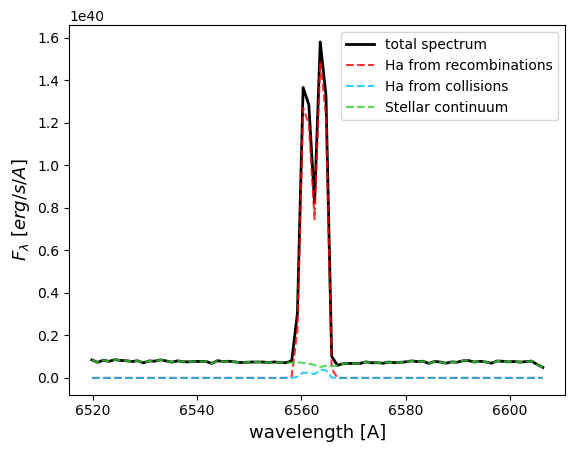

In [34]:
# Define a direction (a number in [1; nmocks])
idir = 1

# read mocks corresponding to the three components
ED = ExperimentDir # just an alias for the 3 lines below. 
contmock = mockobs(ED,'%s/Cont'%ED,'%s/Cont.IC'%ED,load_spectrum=True,idirection=idir)
recmock  = mockobs(ED,'%s/RecHa'%ED,'%s/RecHa.IC'%ED,load_spectrum=True,idirection=idir)
colmock  = mockobs(ED,'%s/ColHa'%ED,'%s/ColHa.IC'%ED,load_spectrum=True,idirection=idir)

# compute total spectrum by adding three components
spec = contmock.spec + recmock.spec + colmock.spec
x    = contmock.spec_lbda_Angstrom  # just an alias
plt.plot(x,spec,lw=2,c='k',label='total spectrum')

# plot each component
plt.plot(x,recmock.spec,c='r',ls='--',alpha=0.8,label='Ha from recombinations')
plt.plot(x,colmock.spec,c='deepskyblue',ls='--',alpha=0.8,label='Ha from collisions')
plt.plot(x,contmock.spec,c='limegreen',ls='--',alpha=0.8,label='Stellar continuum')

# make things pretty
plt.legend()
plt.xlabel('wavelength [A]',fontsize=13)
plt.ylabel(r'$F_\lambda\ [erg/s/A]$',fontsize=13)
plt.show()

#### 4.1.2. Plot spectra observed in all mock directions

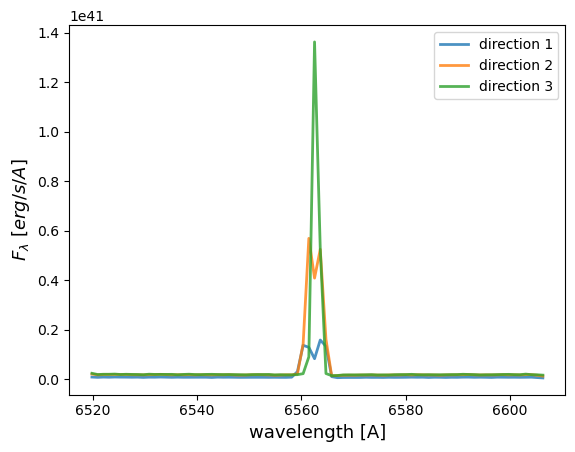

In [35]:
for idir in range(1,nmocks+1):
    # read mocks corresponding to the three components
    ED = ExperimentDir # just an alias for the 3 lines below. 
    contmock = mockobs(ED,'%s/Cont'%ED,'%s/Cont.IC'%ED,load_spectrum=True,idirection=idir)
    recmock  = mockobs(ED,'%s/RecHa'%ED,'%s/RecHa.IC'%ED,load_spectrum=True,idirection=idir)
    colmock  = mockobs(ED,'%s/ColHa'%ED,'%s/ColHa.IC'%ED,load_spectrum=True,idirection=idir)

    # compute total spectrum by adding three components
    spec = contmock.spec + recmock.spec + colmock.spec
    x    = contmock.spec_lbda_Angstrom  # just an alias
    plt.plot(x,spec,lw=2,ls='-',label='direction %i'%idir,alpha=0.8)

# make things pretty
plt.legend()
plt.xlabel('wavelength [A]',fontsize=13)
plt.ylabel(r'$F_\lambda\ [erg/s/A]$',fontsize=13)
plt.show()

### 4.2. Mock images

Here we load the mock images in one random direction (from the nmocks that were computed) and we display the full image and the three components in 4 panels. 

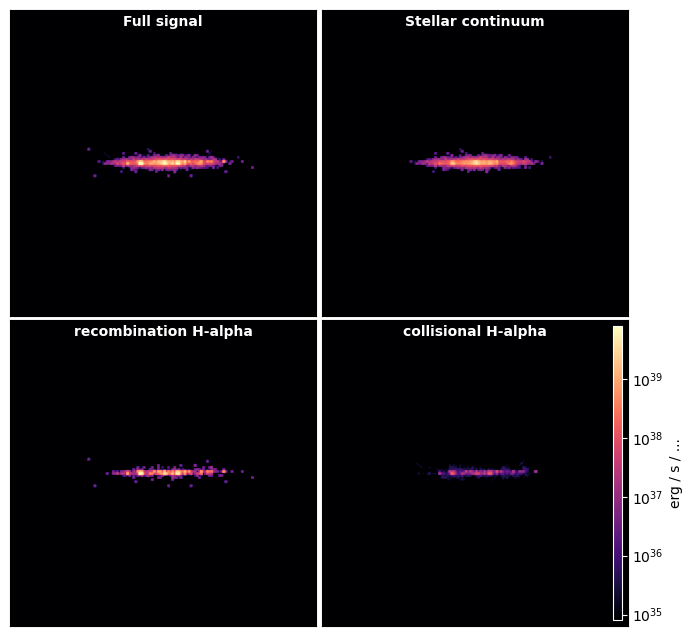

In [36]:
idir = np.random.randint(1,nmocks+1) # chose a random mock with idir between 1 and nmocks

# read mock images from the three components in direction idir:
ED = ExperimentDir # just an alias for the 3 lines below. 
contmock = mockobs(ED,'%s/Cont'%ED,'%s/Cont.IC'%ED,load_image=True,idirection=idir)
recmock  = mockobs(ED,'%s/RecHa'%ED,'%s/RecHa.IC'%ED,load_image=True,idirection=idir)
colmock  = mockobs(ED,'%s/ColHa'%ED,'%s/ColHa.IC'%ED,load_image=True,idirection=idir)

# compute total image 
image = contmock.imtot + recmock.imtot + colmock.imtot
vmax = image.max()/2.
vmin = vmax / 1e5 # don't use image.min() which is zero ... 

# make the plot
from matplotlib import cm 
plt.figure(figsize=(8,8))

cmap = cm.magma
cmap.set_under(cmap(0))
cmap.set_bad(cmap(0))

## top left : total image
ax1  = plt.subplot(221)
imcb = plt.imshow(image.T,norm=LogNorm(vmin=vmin,vmax=vmax),cmap=cmap,origin='lower')
plt.xticks([]); plt.yticks([])
plt.title('Full signal',fontweight='semibold',y=0.92,color='w',fontsize=10)

## top right : stellar continuum image
plt.subplot(222)
plt.imshow(contmock.imtot.T,norm=LogNorm(vmin=vmin,vmax=vmax),cmap=cmap,origin='lower')
plt.xticks([]); plt.yticks([])
plt.title('Stellar continuum',fontweight='semibold',y=0.92,color='w',fontsize=10)

## bottom left : recombination H-alpha
plt.subplot(223)
plt.imshow(recmock.imtot.T,norm=LogNorm(vmin=vmin,vmax=vmax),cmap=cmap,origin='lower')
plt.xticks([]); plt.yticks([])
plt.title('recombination H-alpha',fontweight='semibold',y=0.92,color='w',fontsize=10)

## bottom right : collisional H-alpha
ax1 = plt.subplot(224)
plt.imshow(colmock.imtot.T,norm=LogNorm(vmin=vmin,vmax=vmax),cmap=cmap,origin='lower')
plt.xticks([]); plt.yticks([])
plt.title('collisional H-alpha',fontweight='semibold',y=0.92,color='w',fontsize=10)

## add a colorbar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax1,width="3%",height="96%",loc=4,borderpad=0.4)
cbar = plt.colorbar(imcb,cax=axins,orientation='vertical')
cbar.set_label('erg / s / ...',c='k')
cbar.ax.yaxis.set_tick_params(color='w')# set colorbar tick color
cbar.outline.set_edgecolor('w')# set colorbar edgecolor 
# set colorbar ticklabels
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k')

plt.subplots_adjust(hspace=.01,wspace=.01)
plt.show()

### 4.3 Mock data cubes

#### 4.3.1. load mock cubes and show spatially integrated spectrum

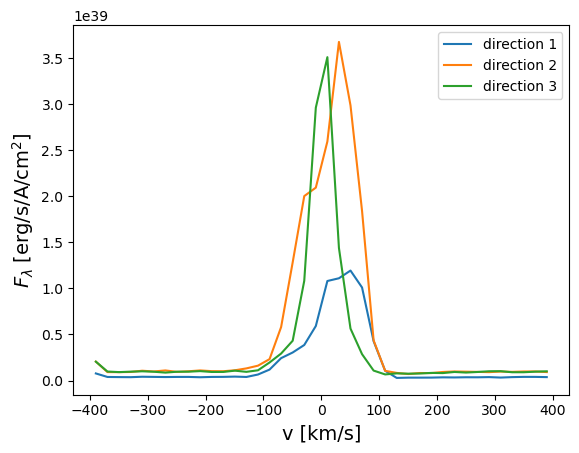

In [37]:
for idir in range(1,nmocks+1):
    ED = ExperimentDir
    contmock = mockobs(ED,'%s/Cont'%ED,'%s/Cont.IC'%ED,load_cube=True,idirection=idir)
    recmock  = mockobs(ED,'%s/RecHa'%ED,'%s/RecHa.IC'%ED,load_cube=True,idirection=idir)
    colmock  = mockobs(ED,'%s/ColHa'%ED,'%s/ColHa.IC'%ED,load_cube=True,idirection=idir)
    # add components into total cube
    total_cube = contmock.cube + recmock.cube + colmock.cube # [erg / s / A / arcsec2 / cm2 ]

    # Compute spectrum
    spectrum = np.sum(total_cube,axis=(0,1)) * contmock.cube_dx_arcsec * contmock.cube_dx_arcsec
    plt.plot(v_from_lambda(contmock.cube_lbda_Angstrom*u.Angstrom),spectrum,label='direction %i'%idir)
    
plt.legend()
plt.xlabel('v [km/s]',fontsize=14)
plt.ylabel(r'$F_\lambda$ [erg/s/A/cm$^2$]',fontsize=14)
plt.show()

#### 4.3.2. Load one cube and compute a mean velocity map

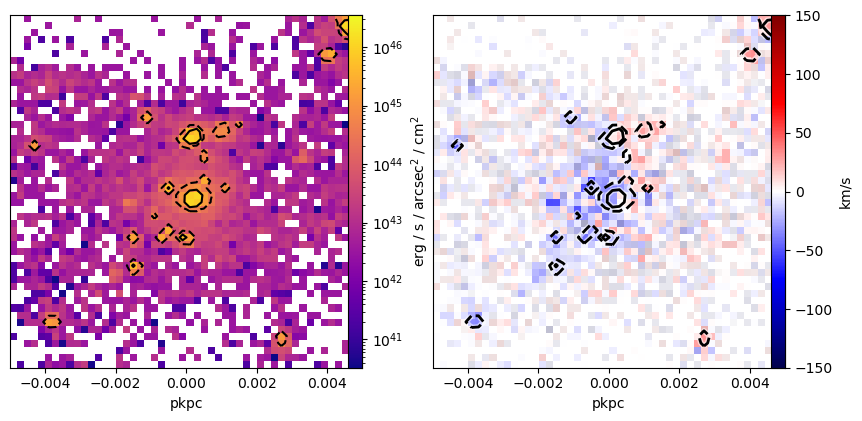

In [38]:
idir = 2
ED = ExperimentDir
contmock = mockobs(ED,'%s/Cont'%ED,'%s/Cont.IC'%ED,load_cube=True,idirection=idir)
recmock  = mockobs(ED,'%s/RecHa'%ED,'%s/RecHa.IC'%ED,load_cube=True,idirection=idir)
colmock  = mockobs(ED,'%s/ColHa'%ED,'%s/ColHa.IC'%ED,load_cube=True,idirection=idir)
# add components into total cube
total_cube = contmock.cube + recmock.cube + colmock.cube # [erg / s / A / arcsec2 / cm2 ]
v = v_from_lambda(contmock.cube_lbda_Angstrom*u.Angstrom)
# compute mean velocity in each pixel [ mean vel is sum_k(flux(i,j,k) * vel(k))/sum_k(flux(i,j,k)) ]
normap = np.sum(total_cube,axis=2) * contmock.cube_dlbda_Angstrom # erg/s/arcsec2/cm2
velmap = np.sum((total_cube*v),axis=2) * contmock.cube_dlbda_Angstrom
ok     = normap > 0
velmap[ok] = velmap[ok]/normap[ok]

# define range of the maps (projected cube) in kpc
unit_l = get_info_param_real(repository,snapnum,'unit_l') # read unit_l from info file to convert box units to cm
cube_side_kpc = (contmock.cube_imsize * unit_l * u.cm).to('kpc')
extent = [-0.5*cube_side_kpc.value, 0.5*cube_side_kpc.value,
          -0.5*cube_side_kpc.value, 0.5*cube_side_kpc.value]


# display the maps
plt.figure(figsize=(10,5))

# Surface brightness map
ax1 = plt.subplot(121)
imcb = plt.imshow(normap.T,cmap='plasma',norm=LogNorm(),extent=extent,origin='lower')
maxval = normap.max()
ct = plt.contour(normap.T,[maxval/1e2,maxval/1e1],extent=extent,
                colors='k',linestyles=['--','-'],origin='lower')
plt.yticks([])
plt.xlabel('pkpc')
## add a colorbar for the SB map
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax1,width="4%",height="100%",loc=1,borderpad=0)
cbar = plt.colorbar(imcb,cax=axins,orientation='vertical')
cbar.set_label(r'erg / s / arcsec$^2$ / cm$^2$',c='k')


# velocity map 
ax2  = plt.subplot(122)
StoN = np.sqrt(normap)     # use this proxy to signal-to-noise to set alpha value of pixels in velocity map
StoN = StoN/StoN.max()*10  # give alpha=1 to all pixels brighter than max flux/10 
StoN[StoN>1] = 1           # saturate alpha to 1
imcb = plt.imshow(velmap.value.T,cmap='seismic',vmin=-150,vmax=150,extent=extent,origin='lower',alpha=StoN.T)
ct   = plt.contour(normap.T,[maxval/1e2,maxval/1e1],extent=extent,
                colors='w',linestyles=['--','-'],origin='lower',linewidths=4,alpha=0.6)
ct   = plt.contour(normap.T,[maxval/1e2,maxval/1e1],extent=extent,
                colors='k',linestyles=['--','-'],origin='lower',linewidths=2)
plt.xlabel('pkpc')
plt.yticks([])
## add a colorbar for the velocity map
axins = inset_axes(ax2,width="4%",height="100%",loc=4,borderpad=0)
cbar = plt.colorbar(imcb,cax=axins,orientation='vertical')
cbar.set_label('km/s',c='k')

plt.show()


#### 4.3.3. Load all cubes and write each one to a fits file
This is really a poor man's implementation ... If you want to use fits files, please do better and commit ! 

In [39]:
for idir in range(1,nmocks+1):
    ED = ExperimentDir
    contmock = mockobs(ED,'%s/Cont'%ED,'%s/Cont.IC'%ED,load_cube=True,idirection=idir)
    recmock  = mockobs(ED,'%s/RecHa'%ED,'%s/RecHa.IC'%ED,load_cube=True,idirection=idir)
    colmock  = mockobs(ED,'%s/ColHa'%ED,'%s/ColHa.IC'%ED,load_cube=True,idirection=idir)
    cube = contmock.cube + recmock.cube + colmock.cube 
    fits.PrimaryHDU(cube.T).writeto('cube_%i.fits'%(idir),overwrite=True)

### 4.4. Angle-averaged results

RASCAS also produces an output file containing the final status of photon packets (for each run, i.e. continuum, and both H-alpha components). These files can be read with functions in the `jphot.py` file. We provide a few examples below.

In [40]:
# load photon packets of three runs
ED    = ExperimentDir
Cont  = jp.photonlist('%s/Cont.IC'%ED, '%s/Cont.res'%ED)
RecHa = jp.photonlist('%s/RecHa.IC'%ED, '%s/RecHa.res'%ED)
ColHa = jp.photonlist('%s/ColHa.IC'%ED, '%s/ColHa.res'%ED)

In [41]:
# select photons that escaped (i.e. not absorbed by dust)
ContEsc = Cont.extract_sample(np.where(Cont.status == 1)[0])
RecHaEsc = RecHa.extract_sample(np.where(RecHa.status == 1)[0])
ColHaEsc = ColHa.extract_sample(np.where(ColHa.status == 1)[0])

In [42]:
# Angle averaged escape fractions
print('Escape fraction of continuum photons : %.1f %%'%(100.*ContEsc.nphoton/Cont.nphoton))
print('Escape fraction of Ha recomb photons : %.1f %%'%(100.*RecHaEsc.nphoton/RecHa.nphoton))
print('Escape fraction of Ha collis photons : %.1f %%'%(100.*ColHaEsc.nphoton/ColHa.nphoton))

Escape fraction of continuum photons : 82.9 %
Escape fraction of Ha recomb photons : 60.2 %
Escape fraction of Ha collis photons : 64.7 %


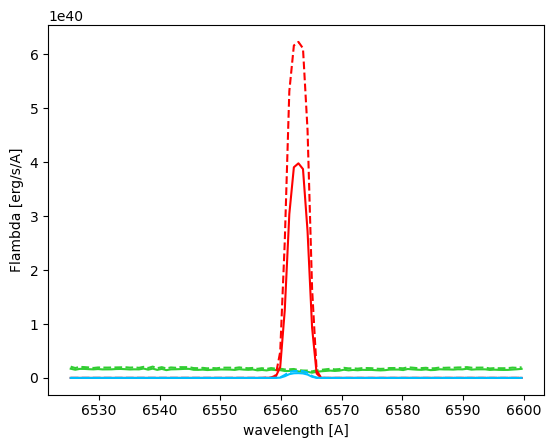

In [43]:
# Compute angle-averaged spectra after and before RT 
x,scont = ContEsc.spectrum(frame='obs',nbins=100,Flambda=True,lmin=6525,lmax=6600)
plt.plot(x,scont,label='Continuum',ls='-',c='limegreen')
x,scont = Cont.spectrum(frame='obs',nbins=100,Flambda=True,lmin=6525,lmax=6600)
plt.plot(x,scont,ls='--',c='limegreen')

x,s = RecHaEsc.spectrum(frame='obs',nbins=100,Flambda=True,lmin=6525,lmax=6600)
plt.plot(x,s,label='Recombinations',ls='-',c='red')
x,s = RecHa.spectrum(frame='obs',nbins=100,Flambda=True,lmin=6525,lmax=6600)
plt.plot(x,s,ls='--',c='red')

x,s = ColHaEsc.spectrum(frame='obs',nbins=100,Flambda=True,lmin=6525,lmax=6600)
plt.plot(x,s,label='Collisions',ls='-',c='deepskyblue')
x,s = ColHa.spectrum(frame='obs',nbins=100,Flambda=True,lmin=6525,lmax=6600)
plt.plot(x,s,ls='--',c='deepskyblue')

plt.xlabel('wavelength [A]')
plt.ylabel('Flambda [erg/s/A]')
plt.show()

## 5. Visualization of the mesh 

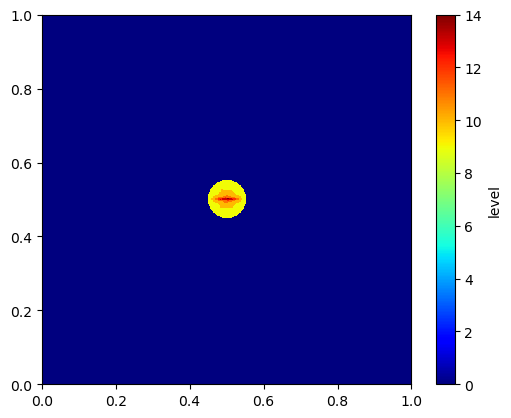

In [44]:
# visualise the mesh

# Short note:
# AMR mesh means that cells have different sizes. Here, we want to visualise the size of the cells. 
# We will make a map of the maximum level of refinement of the cells along the line-of-sight. 
# (Higher refinement level means more resolved, so smallest cells.)
# To better see how resolution changes with radius in the case of the sphere, 
# we will make a map by selecting only cells in a thin slice along the line-of-sight.

import maps as ma
import mesh as me

# read the mesh file
mdom = me.mesh(filename="domain_1.mesh",gasmix="dust")

lmax = np.amax(mdom.gas.leaflevel)
levels = np.array(mdom.gas.leaflevel[:])
positions = mdom.gas.xleaf

# make a map of the maximum level of refinement of the mesh
map, _ = ma.lmax_map(lmax,positions,levels,0.,1.,0.499,0.501,0.,1.,'y')

im = plt.imshow(map.T,interpolation='nearest',origin='lower',
                    extent=(0.,1.,0.,1.),
                    cmap='jet')
cbar = plt.colorbar(im)
cbar.set_label(r'level')
plt.show()

16384


/var/folders/m9/fzv24_5j1kqctbnmcchmyzjc0000gn/T/ipykernel_21569/3558150791.py:22: RuntimeWarning: invalid value encountered in divide
  weighted_map = map/weight


(3277, 3277)


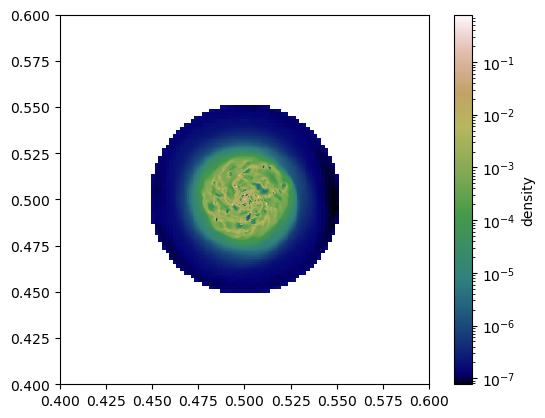

In [45]:
def crop_map(map_in, factor=1):
    npix = map_in.shape[0]
    map_out = map_in[int(npix/2 - npix/factor):int(npix/2 + npix/factor), int(npix/2 - npix/factor):int(npix/2 + npix/factor)]
    return map_out


# make a dust density map
positions = mdom.gas.xleaf
density   = np.array(mdom.gas.ndust)

# select only cells with non-zero density
ii = density > 1.e-15
pos = np.array((positions[0,:][ii],positions[1,:][ii],positions[2,:][ii]))
lev = levels[ii]
dens = density[ii]

map, _ = ma.make_map(lmax,pos,lev,dens,0.,1,0.,1,0.,1,'z')
deno = np.ones(dens.shape)
weight, _ = ma.make_map(lmax,pos,lev,deno,0.,1,0.,1,0.,1.,'z')

print(weight.shape[0])
weighted_map = map/weight
toto = crop_map(weighted_map, factor=10)
print(toto.shape)

from matplotlib.colors import LogNorm

im = plt.imshow(toto.T,interpolation='nearest',origin='lower', 
                norm=LogNorm(),
                extent=(0.4,0.6,0.4,0.6),
                cmap='gist_earth')

cbar = plt.colorbar(im)
cbar.set_label(r'density')
plt.show()